In [10]:
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import juliandate as jd
from astropy.time import Time
import astropy.io.fits as fits
from astropy.table import Table
from astropy.stats import sigma_clip
import seaborn as sns
from scipy.stats import sem

In [11]:
#ztf import
ztf_file = '/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ZTF Data/lc_samiclagn.fits'
ztf_data = fits.open(ztf_file)[1].data

#atlas import
filepath = '/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ATLAS data/job3635727.txt'
catt = []
with open(filepath, 'r') as atlas:

    for i in atlas:
        catt.append(i.split())
    
    cat = np.array(catt)

    o_cat = np.array([])

    mask = (cat[:, 5] == 'o')
    o_cat = cat[mask]


#assasn import
i1 = pd.read_csv('/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ASASSN/asassn_diff_image_lightcurve.csv')
i2 = pd.read_csv('/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ASASSN/asassn_diff_image_added_lightcurve.csv')
i3 = pd.read_csv('/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ASASSN/asassn_image_lightcurve.csv')

### ATLAS CODE

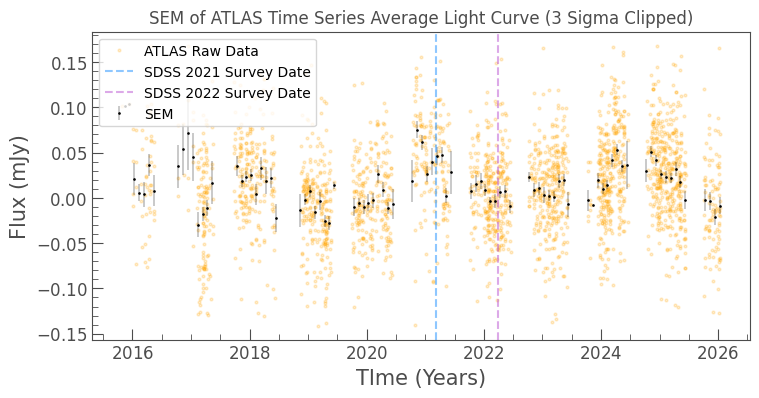

In [21]:
mjd = o_cat[:, 0].astype(float)
flux = o_cat[:, 3].astype(float) / 1000
flux_err = o_cat[:, 4].astype(float) / 1000

sigma = 3

flux_clipped = sigma_clip(flux, sigma=sigma, maxiters=5)
n_mask = ~flux_clipped.mask
mjd_clean = mjd[n_mask]
flux_clean = flux[n_mask]
flux_err_clean = flux_err[n_mask]

t_years = Time(mjd_clean, format='mjd').decimalyear

lc_clean = lk.LightCurve(time=mjd_clean, flux=flux_clean, flux_err=flux_err_clean)
atlas_lc = lk.LightCurve(time=t_years, flux=flux_clean, flux_err=flux_err_clean)

ax = atlas_lc.plot(alpha=0.2, color='orange',marker='o', linestyle='none', label='ATLAS Raw Data')

bin_size = 30.42 # because months are not exactly 30 days
lc_bined = lc_clean.bin(time_bin_size=bin_size)

lc_sem = lc_clean.bin(time_bin_size=bin_size, aggregate_func= lambda x: sem(x, nan_policy='omit'))

lc_bined.flux_err = lc_sem.flux

bin_years = Time(lc_bined.time.value, format='mjd').decimalyear
ax.errorbar(bin_years, lc_bined.flux.value, yerr=lc_bined.flux_err.value, fmt='o', markersize=0.9, lw=0.3, color='black', label='SEM')

plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.title('SEM of ATLAS Time Series Average Light Curve (3 Sigma Clipped)')
plt.ylabel('Flux (mJy)')
plt.xlabel('TIme (Years)')
plt.legend()
plt.show()

### ZTF CODE

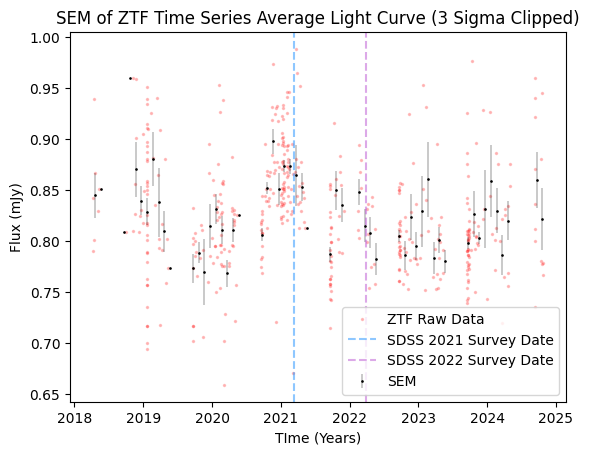

In [34]:
sigma = 3
bin_size = 30.42

ztf_file = '/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ZTF Data/lc_samiclagn.fits'
ztf_data = fits.open(ztf_file)[1].data
mag_ztf = ztf_data['mag']
mag_err_ztf = ztf_data['magerr']
mjd_ztf = ztf_data['mjd']

flux = 3631 * 10**(-0.4 * mag_ztf) * 1000
flux_err = flux * 0.921 * mag_err_ztf

ztf_mjd_lc = lk.LightCurve(time=mjd_ztf, flux=flux, flux_err=flux_err)
ztf_clipped = ztf_mjd_lc.remove_outliers(sigma=sigma)
zt_binned = ztf_clipped.bin(time_bin_size=bin_size)
zt_sem = ztf_clipped.bin(time_bin_size=bin_size, aggregate_func=lambda x: sem(x, nan_policy='omit'))
zt_binned.flux_err = zt_sem.flux
raw_years = Time(ztf_clipped.time.value, format='mjd').decimalyear
binned_years = Time(zt_binned.time.value, format='mjd').decimalyear

plt.plot(raw_years, ztf_clipped.flux.value, alpha=0.2, color='red', 
         marker='o', linestyle='none', label='ZTF Raw Data', markersize=1.5)
plt.errorbar(binned_years, zt_binned.flux.value, yerr=zt_binned.flux_err.value, 
             fmt='o', markersize=0.9, lw=0.3, color='black', label='SEM')

plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.title(f'SEM of ZTF Time Series Average Light Curve ({sigma} Sigma Clipped)')
plt.ylabel('Flux (mJy)')
plt.xlabel('TIme (Years)')
plt.legend()
plt.show()

### ASSASN CODE

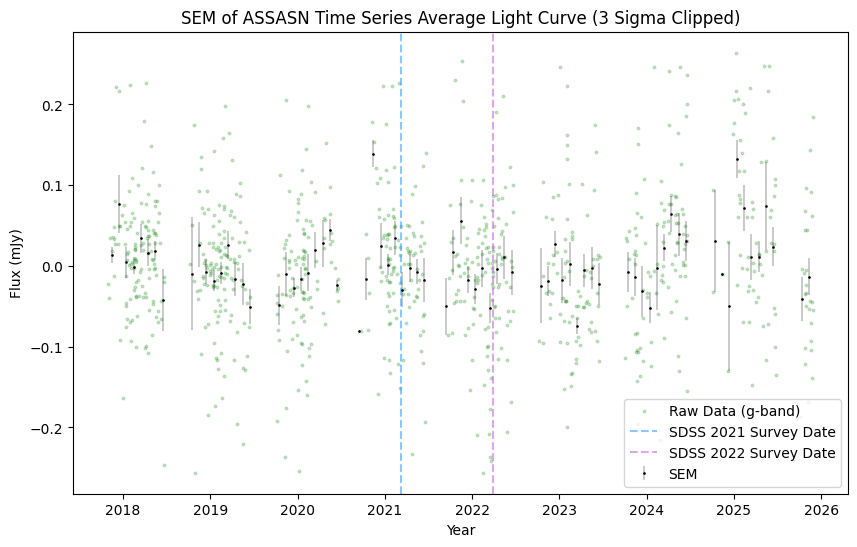

In [36]:
sigma = 3
bin_size = 30.42

i1_V = i1[i1['Filter'] == 'V']
i1_g = i1[i1['Filter'] == 'g']
i2_V = i2[i2['Filter'] == 'V']
i2_g = i2[i2['Filter'] == 'g']

subset = i1_g
band = 'g'

lc_days = lk.LightCurve(time=subset['HJD'], flux=subset['flux(mJy)'], flux_err=subset['flux_err'])
lc_clipped = lc_days.remove_outliers(sigma=sigma)
lc_binned = lc_clipped.bin(time_bin_size=bin_size)
lc_sem = lc_clipped.bin(time_bin_size=bin_size, aggregate_func=lambda x: sem(x, nan_policy='omit'))
lc_binned.flux_err = lc_sem.flux

raw_years = Time(lc_clipped.time.value, format='jd').decimalyear
binned_years = Time(lc_binned.time.value, format='jd').decimalyear

plt.figure(figsize=(10, 6))

plt.plot(raw_years, lc_clipped.flux.value, alpha=0.2, color='green', 
         marker='o', linestyle='none', label=f'Raw Data ({band}-band)', markersize=1.9)

plt.errorbar(binned_years, lc_binned.flux.value, yerr=lc_binned.flux_err.value, 
             fmt='o', markersize=0.9, lw=0.3, color='black', label='SEM')

plt.title(f'SEM of ASSASN Time Series Average Light Curve ({sigma} Sigma Clipped)')
plt.xlabel('Year')
plt.ylabel('Flux (mJy)')
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()